In [2]:
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import pandas as pd
importlib.reload(ApRESDefs)

<module 'ApRESDefs' from '/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py'>

In [3]:
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    21:25:40 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    21:25:40 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    21:25:40 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


In [4]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

In [11]:
def profile_plot(ax,station_ds,name):
    ds = xa.dB(station_ds)
    ds.plot.pcolormesh(ax=ax,x='time')
    ax.invert_yaxis()
    ax.set_title(name)
    

# A101
We will do this analysis station by station. Let's find the attenuator pairs that align. 

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34007")
client

<Client: 'tcp://127.0.0.1:34007' processes=4 threads=16, memory=125.81 GiB>

In [17]:
print('The A101 summer attenuation settings are')
print(f'Atten: {ds_101.attenuator.values[0]}, Gain: {ds_101.AFGain.values[0]}')
print(f'Atten: {ds_101.attenuator.values[1]}, Gain: {ds_101.AFGain.values[1]}')

print('The A101 winter attenuation settings are')
print(f'Atten: {ds_101_w.attenuator.values[0]}, Gain: {ds_101_w.AFGain.values[0]}')
print(f'Atten: {ds_101_w.attenuator.values[1]}, Gain: {ds_101_w.AFGain.values[1]}')

The A101 summer attenuation settings are
Atten: 5.0, Gain: -4
Atten: 5.0, Gain: -14
The A101 winter attenuation settings are
Atten: 10.0, Gain: -4
Atten: 5.0, Gain: -14


Now let's try plotting the whole data series along the same attenuator setting

In [18]:
ds_101_full = xr.concat([ds_101.profile_stacked.isel(attenuator_setting_pair=1),ds_101_w.profile_stacked.isel(attenuator_setting_pair=1)],'time')

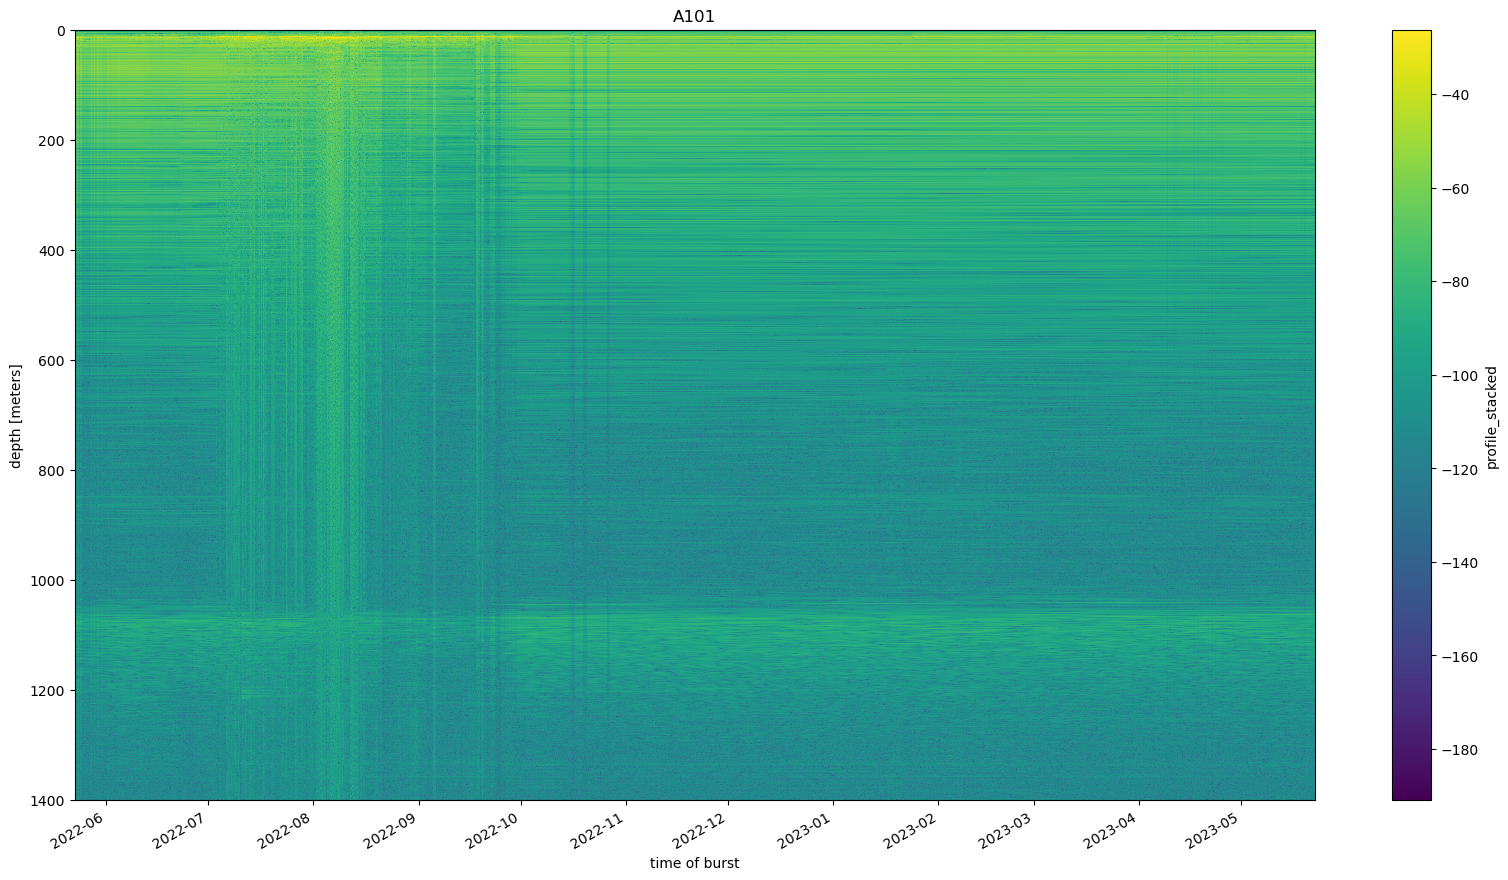

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
profile_plot(ax, ds_101_full, 'A101')

# A103

In [20]:
print('The A103 summer attenuation settings are')
print(f'Atten: {ds_103.attenuator.values[0]}, Gain: {ds_103.AFGain.values[0]}')
print(f'Atten: {ds_103.attenuator.values[1]}, Gain: {ds_103.AFGain.values[1]}')

print('The A103 winter attenuation settings are')
print(f'Atten: {ds_103_w.attenuator.values[0]}, Gain: {ds_103_w.AFGain.values[0]}')
print(f'Atten: {ds_103_w.attenuator.values[1]}, Gain: {ds_103_w.AFGain.values[1]}')

The A103 summer attenuation settings are
Atten: 5.0, Gain: -4
Atten: 5.0, Gain: -14
The A103 winter attenuation settings are
Atten: 5.0, Gain: -4
Atten: 5.0, Gain: -14


In [21]:
ds_103_full = xr.concat([ds_103.profile_stacked.isel(attenuator_setting_pair=1,time=range(100,len(ds_101.time))),ds_103_w.profile_stacked.isel(attenuator_setting_pair=1)],'time')


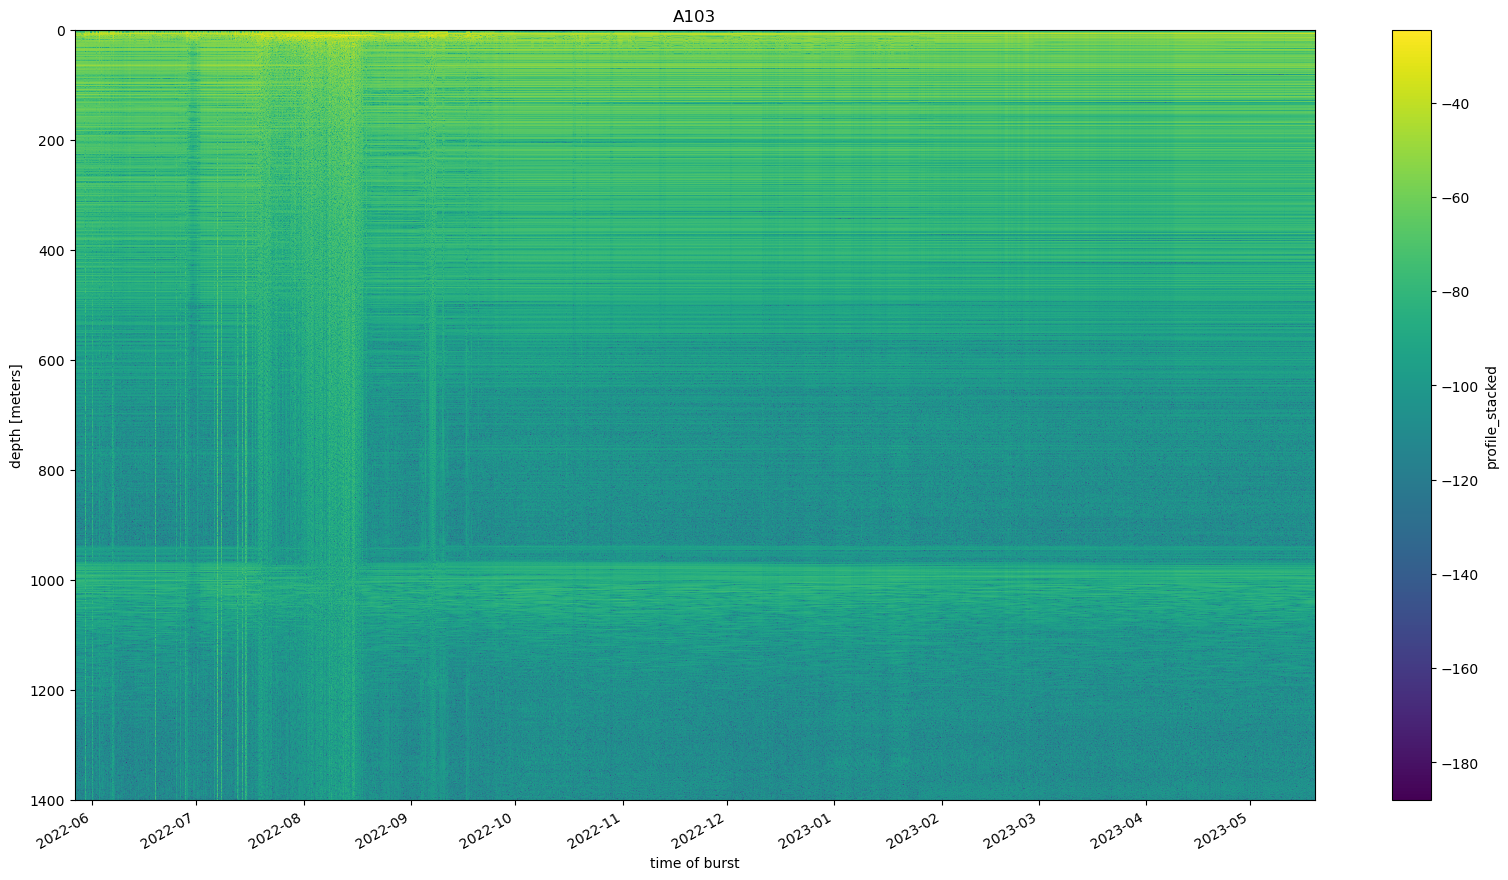

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
profile_plot(ax, ds_103_full, 'A103')

# A104

In [23]:
print('The A104 summer attenuation settings are')
print(f'Atten: {ds_104.attenuator.values[0]}, Gain: {ds_104.AFGain.values[0]}')
print(f'Atten: {ds_104.attenuator.values[1]}, Gain: {ds_104.AFGain.values[1]}')

print('The A104 winter attenuation settings are')
print(f'Atten: {ds_104_w.attenuator.values[0]}, Gain: {ds_104_w.AFGain.values[0]}')
print(f'Atten: {ds_104_w.attenuator.values[1]}, Gain: {ds_104_w.AFGain.values[1]}')

The A104 summer attenuation settings are
Atten: 10.0, Gain: -4
Atten: 10.0, Gain: -14
The A104 winter attenuation settings are
Atten: 10.0, Gain: -4
Atten: 10.0, Gain: -14


In [7]:
ds_104_full = xr.concat([ds_104.profile_stacked.isel(attenuator_setting_pair=1),ds_104_w.profile_stacked.isel(attenuator_setting_pair=1)],'time')

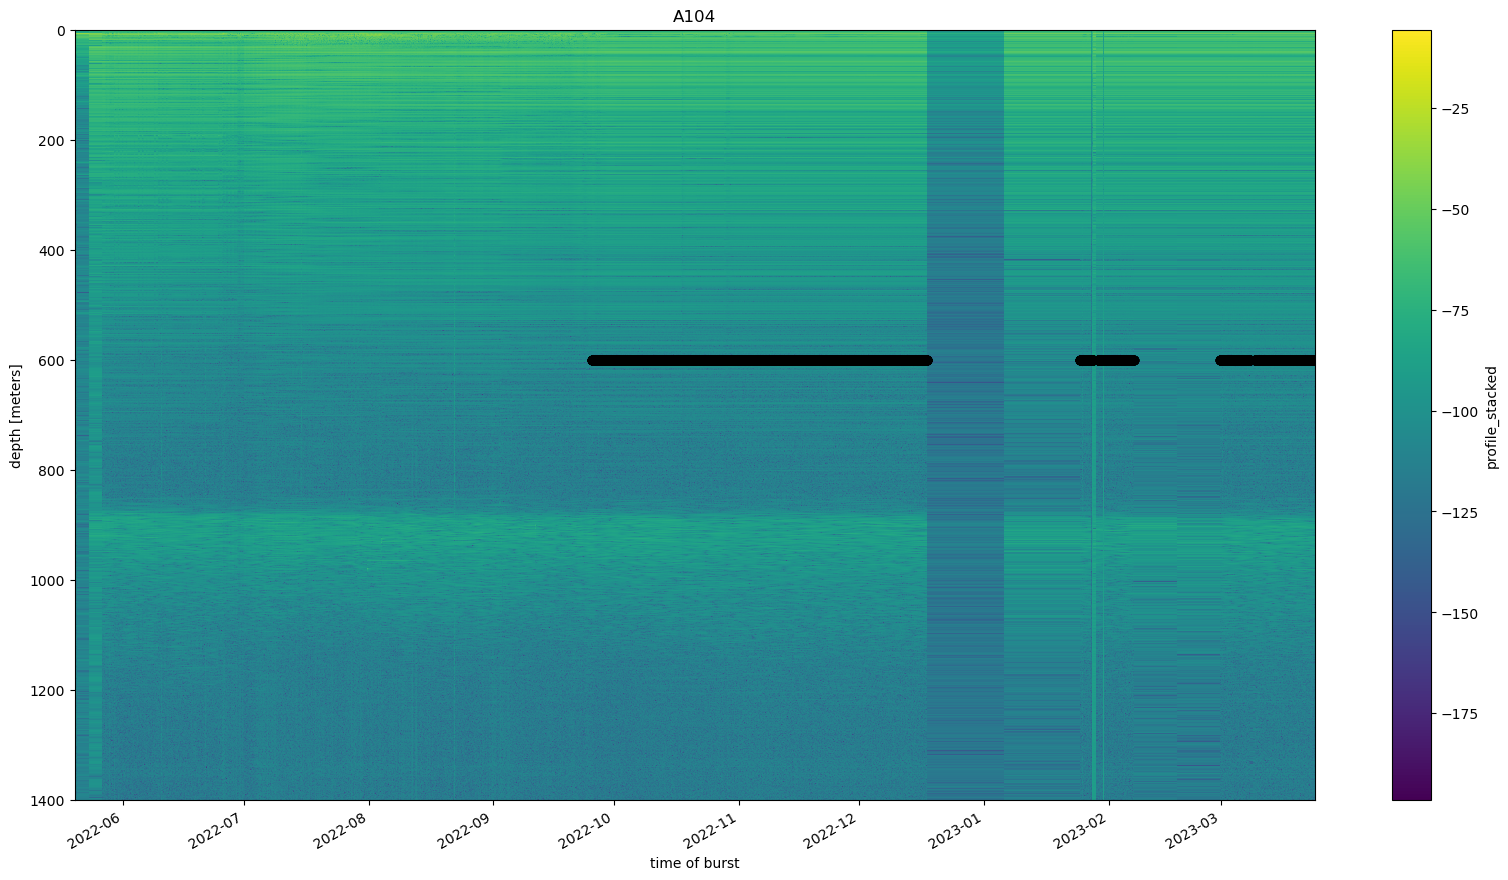

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
profile_plot(ax, ds_104_full, 'A104')
plt.scatter(ds_104_w.time,600*np.ones(np.shape(ds_104_w.time)),color='black')

Takeaway from the above plots is that winter seems uneventful, and A101 and A103 have pretty good data throughout the season, with some occasional clipping. A104 on the other hand has some unusual data starting in late December until March. The next sequence of cells digs into that further.

In [13]:
ds_104_w.isel(attenuator_setting_pair=1)

<xarray.Dataset>
Dimensions:          (time: 11202, chirp_time: 40001, chirp_num: 20,
                      profile_range: 6658)
Coordinates:
    AFGain           int64 dask.array<chunksize=(), meta=np.ndarray>
    attenuator       float64 dask.array<chunksize=(), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U75 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-09-25T13:46:34 ... 2023-03-24...
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num) float64 dask.array<chunksize=(20, 40001, 20), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num) complex128 dask.array<chunksize=(20, 6658, 20), meta=np.ndarray>
    profile_stacked  (time, profile_range) complex128 dask.array<chunksize=(20, 6658), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

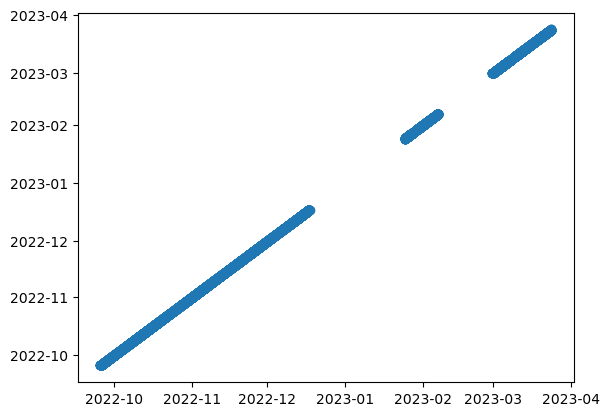

Obvious data gaps happening here